# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [45]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.334856
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ We're running inference on noise, so essentially doing random guessing. In terms of the equations, we can expect the loss on the individual predictions to equal the total loss because we average the individual predictions over all training predictions (and no individual training predictions will on average have any better or worse performance because it's random guessing). The individual training prediction will be:

$$ L_i = -\log\left(\frac{e^{f_{y_i}}}{\sum_{j}e^{f_j}}\right) $$

The exponential on top will on average equal any of the terms being summed on the bottom. Since there are 10 classes/terms on the bottom we should get 0.1. We also set reg = 0.0 when we called the function.

To calculate the gradient, we need to derive what it should be analytically. That is, we need to take the gradient with respect to the weights of:

$$ L_i = -\log\left(\frac{e^{f_{y_i}}}{\sum_{j}e^{f_j}}\right) $$
$$ L_i = -\log\left(\frac{e^{w_{y_i}^T{x_i}}}{\sum_{j}e^{w_{j}^T{x_i}}}\right) $$
$$ L_i = -w_{y_i}^T{x_i} + \log{\sum_{j}e^{w_{j}^T{x_i}}} $$

Taking the gradient with respect to $w_j$ where $j \ne y_i$:

$$ \nabla_{w_j}{L_i} = \nabla_{w_j}\left(\log{\sum_{k}e^{w_{k}^T{x_i}}}\right) $$

Define the following functions where all of $w_{j}$, y, and z are vectors:

$$ L_i = z(w_j) = \log{\sum_{k}e^{w_{k}^T{x_i}}} $$
$$ z(y) = \log{y} $$
$$ y(w_j) = \sum_{k}e^{w_{k}^T{x_i}} $$

Using the chain rule, we have:

$$ \nabla_{w_j}{L_i} = \frac{dz}{dy}\frac{dy}{d{w_j}} = \frac{1}{y}e^{{w_{j}^T{x_i}}}x_i = \frac{e^{{w_{j}^T{x_i}}}x_i}{\sum_{k}e^{w_{k}^T{x_i}}}$$

If we define $\sigma$ as the [softargmax function](https://en.wikipedia.org/wiki/Softargmax), we have:

$$ \nabla_{w_j}{L_i} = \sigma_j\left({w_{j}^T{x_i}}\right)x_i $$

Taking the gradient with respect to $w_{y_i}$:

$$ \nabla_{w_{y_i}}{L_i} = -{x_i} + \sigma_j\left({w_{j}^T{x_i}}\right)x_i = \left(\sigma_j\left({w_{j}^T{x_i}}\right) - 1\right)x_i $$

In [49]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
print("Without regularization: ")
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
print("With regularization: ")
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

Without regularization: 
numerical: -2.067644 analytic: -2.067644, relative error: 4.129306e-09
numerical: -0.861844 analytic: -0.861844, relative error: 1.240615e-08
numerical: 4.057439 analytic: 4.057439, relative error: 1.823344e-08
numerical: 0.895648 analytic: 0.895648, relative error: 3.942102e-08
numerical: 4.943435 analytic: 4.943435, relative error: 1.829952e-09
numerical: 2.393567 analytic: 2.393568, relative error: 6.835286e-09
numerical: 1.687066 analytic: 1.687066, relative error: 4.306855e-09
numerical: -2.551863 analytic: -2.551863, relative error: 4.742086e-09
numerical: 0.008674 analytic: 0.008674, relative error: 2.406765e-06
numerical: 1.116042 analytic: 1.116042, relative error: 4.475085e-08
With regularization: 
numerical: 0.905831 analytic: 0.905831, relative error: 4.430087e-08
numerical: 0.719829 analytic: 0.719829, relative error: 7.458071e-08
numerical: 2.464845 analytic: 2.464845, relative error: 2.177961e-09
numerical: -3.174575 analytic: -3.174575, relative

In [56]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.334856e+00 computed in 0.182848s
vectorized loss: 2.334856e+00 computed in 0.003889s
Loss difference: 0.000000
Gradient difference: 0.000000


In [58]:
import itertools

# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

num_iters = 1500
tic = time.time()

def train_validate_softmax(learning_rate, reg):
    softmax = Softmax()
    softmax.train(X_train, y_train, learning_rate=learning_rate, reg=reg,
                  num_iters=num_iters, verbose=True)
    y_train_pred = np.mean(y_train == softmax.predict(X_train))
    y_val_pred = np.mean(y_val == softmax.predict(X_val))
    return (y_train_pred, y_val_pred, softmax)

combinations = itertools.product(*[learning_rates, regularization_strengths])
full_results = {(lr, reg): (train_validate_softmax(lr, reg)) for lr, reg in combinations}
sorted_by_validation_error = sorted(full_results.values(), key=lambda tup: tup[1])
_, best_val, best_softmax = sorted_by_validation_error[-1]

results = {x: (y, z) for x, (y, z, _) in full_results.items()}

toc = time.time()
print('That took %fs' % (toc - tic))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 4.671615
iteration 100 / 1500: loss 2.715319
iteration 200 / 1500: loss 2.117726
iteration 300 / 1500: loss 2.033182
iteration 400 / 1500: loss 2.008147
iteration 500 / 1500: loss 2.047898
iteration 600 / 1500: loss 2.022581
iteration 700 / 1500: loss 1.989967
iteration 800 / 1500: loss 2.014506
iteration 900 / 1500: loss 1.960029
iteration 1000 / 1500: loss 1.984336
iteration 1100 / 1500: loss 2.041111
iteration 1200 / 1500: loss 1.993745
iteration 1300 / 1500: loss 1.969315
iteration 1400 / 1500: loss 1.982031
iteration 0 / 1500: loss 6.603374
iteration 100 / 1500: loss 2.422181
iteration 200 / 1500: loss 2.010574
iteration 300 / 1500: loss 2.064718
iteration 400 / 1500: loss 2.070938
iteration 500 / 1500: loss 2.065326
iteration 600 / 1500: loss 2.030961
iteration 700 / 1500: loss 2.072583
iteration 800 / 1500: loss 2.060285
iteration 900 / 1500: loss 2.096678
iteration 1000 / 1500: loss 2.101847
iteration 1100 / 1500: loss 2.050478
iteration 1200 / 1500: lo

In [59]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.344000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ Yes


$\color{blue}{\textit Your Explanation:}$ If the $W$ in the SVM is already well-trained (and potentially even if it's not), it's possible to come up with a training example that leads to no "missed margins" (all margins are less than delta). If that's the training example we add, it won't affect the gradient (or the loss).



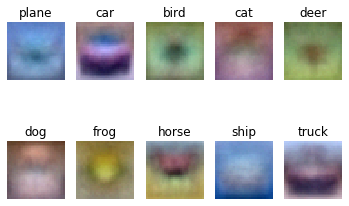

In [60]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])